In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        print("initialization")
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 10       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.

#         self.func1 = nn.RNNCell(self.input_size, self.hidden_size)
        self.func1 = nn.GRUCell(self.input_size, self.hidden_size)##, num_layers=1, bidirectional = False)
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
#         self.embedding = nn.Embedding(self.input_size, self.hidden_size)

        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
#         input = input.unsqueeze(0) 
#         print("hidden:")
#         print(hidden)
#         print(input.shape)
#         print(hidden.shape)
#         hidden = hidden.unsqueeze(0) 
#         if hidden.shape != input.shape:
#             hidden = hidden.unsqueeze(0)
#         print("after")
#         print (hidden.shape)
        hidden = self.func1(input, hidden)###### To be filled ######
#         print(hidden.shape)
        output = self.func2(hidden)###### To be filled ######
#         output = output.squeeze(0)
#         hidden = hidden.squeeze(0)
        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
#         return torch.zeros(1, self.hidden_size).to(device) 
        return torch.zeros(1, self.hidden_size).to(device) #, torch.zeros(1, self.hidden_size).to(device)
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

initialization


Net(
  (func1): GRUCell(100, 10)
  (func2): Linear(in_features=10, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.

    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
#         print(net(input, hidden))
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 12500  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/12500 loss:3.580803155899048
generated sequence: W p Yu,ti
i st iibo hlrckAr
hw  tNdneihizfnvm tr  ekaodRmedi nM sreti:'s. .tei n,EifegaseTiunTk,eeo  

iter:199/12500 loss:3.2147326469421387
generated sequence: W7ntey,et rsmwyaarL a
R'f,tiys tll aiI ,win h,ohtl eesethh
wr?
mienI c r - cumdHiAcenU;8A:uelslniee
c

iter:299/12500 loss:2.9969265460968018
generated sequence: WOUbft T  anehianiuusaodvdhhaob y i  tsmihvwasliak AuN

d 'rWia
A ldll ss n wa;ecpdii oat,;
Stsn Aoea

iter:399/12500 loss:2.7921037673950195
generated sequence: W?
ANOYee g,wwoascer,
At nvy Hit eotttoZ!re kttees in ithoo3hs cthc, mrus -otohed,f cheil
C9ois tuoas

iter:499/12500 loss:2.6438684463500977
generated sequence: WEB~Nth srer thatka
Thy hpeoieo,
Thorpro n use
LM
Hfnlleh;? thoe ar wrh men weurrlgik bX f
Bineh and 

iter:599/12500 loss:2.5757861137390137
generated sequence: Womdnle qhan:Tre fuf mke orvtre cosrnv.I thisf thid ke mor thrt orie'g.
I iohs pe thotuemlit tit lere

iter:699/12500 loss:2.50114488

#### Training Loss Curve

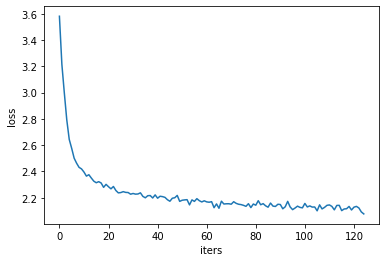

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

Wa, and atit muct. Bun day?

BETEg:
deen cons whouge wame;
And me wincightery to k on guth 'gaalle brikest?

AUCENTIO:
And onin, uvers so ane,
Uich the saved have.

BUSO:
Erpemite seam. chake prey that cum, trett as to bestes, anh us I dyerst thaa me
as king!
Fall wern.

HOCTO:
Wherep wenst in of to I
IL:
Bun, wyon a ir.

VOLA:
Wee; heart stige?

HARRO:

Coren iere,
And sto fome thered.

Parrits mse my Elst hanged tade as' tear!, beeder!
Wheirle I hile.

GLOUMENsT:
He wemand mat.

WUVO:
Wene sem the, to fenncunit bes Gling,
A well is leed baco wo of, ngruthind,
Who
of prot of bithime wo hends t


In [11]:
import numpy as np
f = open("GRU_10.npy", "w")
a = [data.item() for data in all_losses]
a

[3.580803155899048,
 3.2147326469421387,
 2.9969265460968018,
 2.7921037673950195,
 2.6438684463500977,
 2.5757861137390137,
 2.5011448860168457,
 2.4628796577453613,
 2.431365966796875,
 2.4195356369018555,
 2.3955798149108887,
 2.3646960258483887,
 2.3753485679626465,
 2.3500125408172607,
 2.326481819152832,
 2.3142306804656982,
 2.322467088699341,
 2.312328815460205,
 2.2792961597442627,
 2.30188250541687,
 2.2840049266815186,
 2.2679057121276855,
 2.285781145095825,
 2.2553067207336426,
 2.2371323108673096,
 2.2394769191741943,
 2.246412992477417,
 2.2408206462860107,
 2.2397446632385254,
 2.2270877361297607,
 2.2325479984283447,
 2.227525472640991,
 2.228742837905884,
 2.237510919570923,
 2.2105002403259277,
 2.1998255252838135,
 2.215717315673828,
 2.2169013023376465,
 2.198329210281372,
 2.221911907196045,
 2.1967012882232666,
 2.2114834785461426,
 2.208693504333496,
 2.2030081748962402,
 2.1852760314941406,
 2.173478603363037,
 2.1963307857513428,
 2.2002148628234863,
 2.217815

In [12]:
np.save("GRU_10.npy", a)
np.load("GRU_10.npy")

array([3.58080316, 3.21473265, 2.99692655, 2.79210377, 2.64386845,
       2.57578611, 2.50114489, 2.46287966, 2.43136597, 2.41953564,
       2.39557981, 2.36469603, 2.37534857, 2.35001254, 2.32648182,
       2.31423068, 2.32246709, 2.31232882, 2.27929616, 2.30188251,
       2.28400493, 2.26790571, 2.28578115, 2.25530672, 2.23713231,
       2.23947692, 2.24641299, 2.24082065, 2.23974466, 2.22708774,
       2.232548  , 2.22752547, 2.22874284, 2.23751092, 2.21050024,
       2.19982553, 2.21571732, 2.2169013 , 2.19832921, 2.22191191,
       2.19670129, 2.21148348, 2.2086935 , 2.20300817, 2.18527603,
       2.1734786 , 2.19633079, 2.20021486, 2.21781588, 2.17258668,
       2.18118548, 2.18373418, 2.18552113, 2.1459415 , 2.18379807,
       2.17226529, 2.19313955, 2.17764068, 2.16815543, 2.17692304,
       2.1686697 , 2.16598606, 2.17025638, 2.12449908, 2.15319157,
       2.12018132, 2.17402911, 2.15246582, 2.15423083, 2.15457177,
       2.1509459 , 2.16991591, 2.15752912, 2.15072131, 2.14800

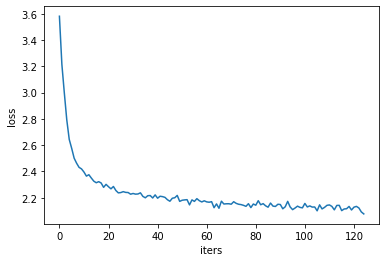

In [13]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("GRU_10.npy"))
plt.show()

ValueError: Cannot load file containing pickled data when allow_pickle=False

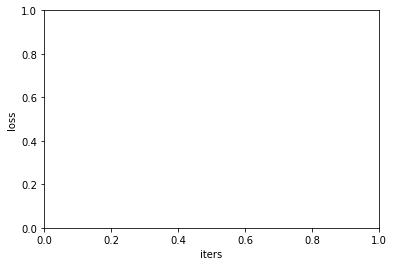

In [14]:
import numpy as np
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN.npy"), label='RNN(Relu)')
plt.plot(np.load("original_RNN_tanh.npy"), label='RNN(tanh)')
plt.plot(np.load("rnn_LSTM.npy"), label='LSTM')
plt.legend(loc='best')
plt.plot(np.load("GRU_100.npy"), label='GRU')
plt.show()